# Le notebook que yohan n'a pas fait

In [1]:
import pandas as pd
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import os
import matplotlib.colors as colors
from matplotlib.cm import bwr as cmap
import matplotlib.patches as mpatches

In [2]:
caracteristiques = pd.read_csv('./Dataset/all_years/caracteristiques-2019-22.csv')
departements = pd.read_csv('./Dataset/departements-france.csv')
lieux = pd.read_csv('./Dataset/all_years/lieux-2019-22.csv')
usager = pd.read_csv('./Dataset/all_years/usagers-2019-22.csv')
vehicule = pd.read_csv('./Dataset/all_years/vehicules-2019-22.csv')

In [3]:
def merge_vehicle_count(caracteristiques, vehicules):
    # Compter le nombre de véhicules par "Num_Acc" dans le DataFrame vehicules
    vehicules_count = vehicules.groupby("Accident_Id")["id_vehicule"].count().reset_index().rename(columns={'id_vehicule':'Nombre_vehicule'})
    
    # Fusionner le DataFrame caracteristiques avec le DataFrame vehicules_count en utilisant la colonne "Num_Acc"
    merged_df = caracteristiques.merge(vehicules_count, on='Accident_Id')
    
    return merged_df


def merge_user_count(caracteristiques,usagers):
    # Compter le nombre d'usagers par "Accident_Id" et par sexe dans le DataFrame usagers
    usagers_count = usagers.groupby(["Accident_Id", "sexe"])["id_vehicule"].count().unstack(fill_value=0)
    usagers_count.rename(columns={1: 'Nombre_Hommes', 2: 'Nombre_Femmes'}, inplace=True)
    
    # Fusionner le DataFrame caracteristiques avec usagers_count en utilisant la colonne "Num_Acc"
    merged_df = caracteristiques.merge(usagers_count, on='Accident_Id')
    
    return merged_df

def replace_with_mapper(df, col, mapper):
    df[col] = df[col].replace(mapper)
    
    return df

# Remplacement des heures par le moment de la journée
matinee = ['06:','07:','08:','09:','10:']
journee = ['11:','12:','13:','14:','15:','16:','17:']
soiree = ['18:','19:','20:','21:','22:','23:']
nuit = ['00:','01:','02:','03:','04:','05:']

def replace_hour(hour):
    hour = hour[:3]
    if hour in matinee:
        return 'Matinée'
    elif hour in journee:
        return 'Journée'
    elif hour in soiree:
        return 'Soirée'
    elif hour in nuit:
        return 'Nuit'
    else:
        'Lucas'

In [4]:
years = ['19', '20', '21', '22']
files_name = ["caracteristiques-20", "lieux-20", "usagers-20", "vehicules-20"]
if not os.path.exists('./Dataset/all_years'):
    os.mkdir('./Dataset/all_years/', 0o666) 
for file_name in files_name:
    result = []
    for year in years:
        file_path = f'./Dataset/{year}/{file_name}{year}.csv'
        sep = ';'
        df = pd.read_csv(file_path, sep=sep, low_memory=False)
        # if 'id_usager' in df.columns:
        #     df = df.drop(columns=['id_usager'])
        result.append(df)
    combined_df = pd.concat(result, ignore_index=True)
    combined_df.to_csv(f'./Dataset/all_years/{file_name}{years[0]}-{years[-1]}.csv', index=False)

In [5]:
caracteristiques = caracteristiques.drop(['com', 'adr', 'lat', 'long'], axis=1)

# Remplacer les numéros des mois par leurs noms
caracteristiques.mois = caracteristiques.mois.map({
    1:'Janvier',
    2:'Février',
    3:'Mars',
    4:'Avril',
    5:'Mai',
    6:'Juin',
    7:'Juillet',
    8:'Août',
    9:'Septembre',
    10:'Octobre',
    11:'Novembre',
    12:'Décembre'
}, na_action=None)

caracteristiques.hrmn = caracteristiques.hrmn.apply(replace_hour)

caracteristiques = replace_with_mapper(caracteristiques, 'lum', {
    1 : 'Plein jour',
    2 : 'Crépuscule ou aube',
    3 : 'Nuit sans éclairage public',
    4 : 'Nuit avec éclairage public non allumé',
    5 : 'Nuit avec éclairage public allumé'
})

# Remplacer les numéros de départements par leur noms
departements_mapper = departements.set_index('code_departement')['nom_departement'].to_dict()
caracteristiques = replace_with_mapper(caracteristiques, 'dep', departements_mapper)

caracteristiques = replace_with_mapper(caracteristiques, 'agg', {
    1 : 'Hors agglomération',
    2 : 'En agglomération'
})
caracteristiques = replace_with_mapper(caracteristiques, 'int', {
    1 : 'Hors intersection',
    2 : 'Intersection en X',
    3 : 'Intersection en T',
    4 : 'Intersection en Y',
    5 : 'Intersection à plus de 4 branches',
    6 : 'Giratoire',
    7 : 'Place',
    8 : 'Passage à niveau',
    9 : 'Autre intersection'
})
caracteristiques = replace_with_mapper(caracteristiques, 'atm', {
    -1 :'Non renseigné',
    1 : 'Normale',
    2 : 'Pluie légère',
    3 : 'Pluie forte',
    4 : 'Neige - grêle',
    5 : 'Brouillard - fumée',
    6 : 'Vent fort - tempête',
    7 : 'Temps éblouissant',
    8 : 'Temps couvert',
    9 : 'Autre'
})
caracteristiques = replace_with_mapper(caracteristiques, 'col', {
    -1 :'Non renseigné',
    1 : 'Deux véhicules - frontale',
    2 : 'Deux véhicules – par l’arrière',
    3 : 'Deux véhicules – par le coté',
    4 : 'Trois véhicules et plus – en chaîne',
    5 : 'Trois véhicules et plus - collisions multiples',
    6 : 'Autre collision',
    7 : 'Sans collision'
})

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'catr']], 'catr', {
    1:'Autoroute',
    2:'Route nationale',
    3:'Route Départementale',
    4:'Voie Communales',
    5:'Hors réseau public',
    6:'Parc de stationnementouvert à la circulation publique',
    7:'Routes de métropole urbaine',
    9:'autre'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'circ']], 'circ', {
    -1:'Non renseigné',
    1:'A sens unique',
    2:'Bidirectionnelle',
    3:'A chaussées séparées',
    4:'Avec voies d’affectation variable'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(lieux.loc[:, ['Accident_Id', 'nbv']], on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'surf']], 'surf', {
    -1:'Non renseigné',
    1:'Normale',
    2:'Mouillée',
    3:'Flaques',
    4:'Inondée',
    5:'Enneigée',
    6:'Boue',
    7:'Verglacée',
    8:'Corps gras – huile',
    9:'Autre'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'infra']], 'infra', {
    -1:'Non renseigné',
    0:'Aucun',
    1:'Souterrain -tunnel',
    2:'Pont -autopont',
    3:'Bretelle d’échangeur ou de raccordement',
    4:'Voie ferrée',
    5:'Carrefour aménagé',
    6:'Zone piétonne',
    7:'Zone de péage',
    8:'Chantier',
    9:'Autres'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'situ']], 'situ', {
    -1:'Non renseigné',
    0:'Aucun',
    1:'Sur chaussée',
    2:'Sur bande d’arrêt d’urgence',
    3:'Sur accotement',
    4:'Sur trottoir',
    5:'Sur piste cyclable',
    6:'Sur autre voie spéciale',
    8:'Autres'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(lieux.loc[:, ['Accident_Id', 'vma']], on='Accident_Id', how='left')

caracteristiques.rename(columns={
    'an': 'année',
	'hrmn': 'horraire',
    'lum': 'luminosité',
    'dep': 'département',
    'agg': 'agglomération',
    'int': 'intersection',
    'atm': 'atmosphere',
    'col': 'collision',
    'catr': 'catégorie de route',
    'circ': 'régime de circulation',
    'nbv': 'nombre de voix',
    'surf': 'etat de la surface',
    'infra': 'infrastructure',
    'situ': 'situation',
    'vma': 'vitesse max autorisée'
}, inplace=True)

caracteristiques.head(5)

,Accident_Id,jour,mois,année,horraire,luminosité,département,agglomération,intersection,atmosphere,collision,catégorie de route,régime de circulation,nombre de voix,etat de la surface,infrastructure,situation,vitesse max autorisée
0,201900000001,30,Novembre,2019,Nuit,Nuit avec éclairage public non allumé,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,Deux véhicules – par l’arrière,Autoroute,A chaussées séparées,10,Normale,Pont -autopont,Sur chaussée,70
1,201900000002,30,Novembre,2019,Nuit,Nuit sans éclairage public,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,Autre collision,Autoroute,A sens unique,2,Normale,Aucun,Sur chaussée,70
2,201900000003,28,Novembre,2019,Journée,Plein jour,Hauts-de-Seine,Hors agglomération,Hors intersection,Normale,Trois véhicules et plus – en chaîne,Autoroute,A chaussées séparées,8,Normale,Aucun,Sur chaussée,90
3,201900000004,30,Novembre,2019,Soirée,Nuit avec éclairage public allumé,Val-de-Marne,Hors agglomération,Hors intersection,Normale,Trois véhicules et plus – en chaîne,Autoroute,A chaussées séparées,5,Normale,Aucun,Sur chaussée,90
4,201900000005,30,Novembre,2019,Nuit,Nuit sans éclairage public,Val-de-Marne,Hors agglomération,Hors intersection,Normale,Deux véhicules – par l’arrière,Autoroute,A sens unique,3,Normale,Pont -autopont,Sur chaussée,90


In [6]:
vehicule['catv'] = vehicule['catv'].replace([0, 99, -1],  ['indéterminable', 'autre véhicule', 'indéterminé'])
vehicule['catv'] = vehicule['catv'].replace([10, 13, 14, 15, 16, 17, 20, 21, 37, 38, 39, 40], 'vehicules lourd')
vehicule['catv'] = vehicule['catv'].replace([3, 7, 35, 36, 50, 60], 'vehicules leger')
vehicule['catv'] = vehicule['catv'].replace([1, 2, 30, 31, 32, 33, 34, 41, 42, 43, 80], 'vehicules deux roues')

r = vehicule.groupby('Accident_Id')['catv'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r[['indéterminable', 'autre véhicule', 'indéterminé', 'vehicules lourd', 'vehicules leger', 'vehicules deux roues']] = r[['indéterminable', 'autre véhicule', 'indéterminé', 'vehicules lourd', 'vehicules leger', 'vehicules deux roues']].astype(int)
caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

caracteristiques.head(5)


r = usager.groupby('Accident_Id')['grav'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    -1:'gravité indéterminé',
    1:'indemne',
    2:'tué',
    3:'blessé hospitalisé',
    4:'blessé léger'
}, inplace=True)
r[['gravité indéterminé', 'indemne', 'tué', 'blessé hospitalisé', 'blessé léger']] = r[['gravité indéterminé', 'indemne', 'tué', 'blessé hospitalisé', 'blessé léger']].astype(int)

caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

r = usager.groupby('Accident_Id')['sexe'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    -1:'autre',
    1:'hommes',
    2:'femmes'
}, inplace=True)
r[['autre', 'hommes', 'femmes']] = r[['autre', 'hommes', 'femmes']].astype(int)

caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

usager['année'] = usager['Accident_Id'].map(caracteristiques.set_index('Accident_Id')['année'])
usager['age_category'] = pd.cut(
    usager['année'] - usager['an_nais'],
    bins=[0, 18, 59, float('inf')],
    labels=["jeune", "adulte", "senior"],
    right=True
)

number_of_people = usager.groupby(by='Accident_Id')['age_category'].value_counts().unstack().fillna(0)
number_of_people.reset_index(inplace=True)

caracteristiques = caracteristiques.merge(number_of_people, on='Accident_Id', how='right')

# Clean
usager.drop(columns=['année'])
usager.drop(columns=['age_category'])

r = usager.groupby('Accident_Id')['catu'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    1:'conducteur',
    2:'passager',
    3:'piéton'
}, inplace=True)
r[['conducteur', 'passager', 'piéton']] = r[['conducteur', 'passager', 'piéton']].astype(int)
caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

display(caracteristiques.info())
caracteristiques.sort_values(by="département").head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218404 entries, 0 to 218403
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Accident_Id             218404 non-null  int64 
 1   jour                    218404 non-null  int64 
 2   mois                    218404 non-null  object
 3   année                   218404 non-null  int64 
 4   horraire                218404 non-null  object
 5   luminosité              218404 non-null  object
 6   département             218404 non-null  object
 7   agglomération           218404 non-null  object
 8   intersection            218404 non-null  object
 9   atmosphere              218404 non-null  object
 10  collision               218404 non-null  object
 11  catégorie de route      218404 non-null  object
 12  régime de circulation   218404 non-null  object
 13  nombre de voix          218404 non-null  object
 14  etat de la surface      218404 non-n

None

,Accident_Id,jour,mois,année,horraire,luminosité,département,agglomération,intersection,atmosphere,...,blessé léger,autre,hommes,femmes,jeune,adulte,senior,conducteur,passager,piéton
192169,202200029068,31,Août,2022,Journée,Plein jour,Ain,En agglomération,Hors intersection,Normale,...,1,0,1,0,0,1,0,1,0,0
113467,202100006884,12,Novembre,2021,Journée,Nuit sans éclairage public,Ain,Hors agglomération,Hors intersection,Normale,...,1,0,2,2,0,3,1,2,2,0
73064,202000014225,25,Décembre,2020,Matinée,Plein jour,Ain,Hors agglomération,Intersection en T,Temps couvert,...,0,0,1,0,0,0,1,1,0,0
101629,202000042790,25,Juillet,2020,Journée,Plein jour,Ain,Hors agglomération,Hors intersection,Normale,...,0,0,3,0,0,2,1,3,0,0
136696,202100030113,9,Juillet,2021,Journée,Plein jour,Ain,En agglomération,Intersection en T,Normale,...,1,0,2,0,0,1,1,2,0,0
136695,202100030112,8,Juillet,2021,Matinée,Plein jour,Ain,En agglomération,Hors intersection,Normale,...,1,0,2,0,0,1,1,1,0,1
163619,202200000518,21,Octobre,2022,Matinée,Plein jour,Ain,En agglomération,Intersection en T,Pluie légère,...,0,0,0,2,0,1,1,2,0,0


In [7]:
columns_name = caracteristiques.iloc[:,17:].columns

## Normalisation des données

In [8]:
from sklearn.preprocessing import StandardScaler

## Analyse en composantes principales

In [9]:
from sklearn.decomposition import PCA

In [10]:


def print_top_comp(components, feature_names, n_top_comp):
    seuil=1/np.sqrt(len(feature_names))-0.02
    for comp_idx, topic in enumerate(components):
        feature_pos=feature_names[topic>=seuil]
        feature_neg=feature_names[topic<-seuil]
        n_top_comp_pos=min(n_top_comp,feature_pos.shape[0])
        n_top_comp_neg=min(n_top_comp,feature_neg.shape[0])
        feature_pos=feature_names[topic.argsort()[::-1][:n_top_comp_pos]]
        feature_neg=feature_names[topic.argsort()[:n_top_comp_neg]]
        fea=np.concatenate((feature_pos,feature_neg))
        com_pos=np.sort(topic)[::-1][:n_top_comp_pos]
        com_neg=np.sort(topic)[:n_top_comp_neg]
        com=np.concatenate((com_pos,com_neg))
                
        c_normal = colors.PowerNorm(1,vmin=min(com),vmax=max(com))
        _COLORS = cmap(c_normal(com))
                       
        components = pd.DataFrame(np.array(com),index =fea) 
        fig, ax = plt.subplots(figsize = (5,3))
        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar',align = "center", color=_COLORS)
        #plt.xlabel("Dimension #%d " % comp_idx)
        ax.set_ylabel("Feature Weights") 
        red_patch = mpatches.Patch(color='red', label="Composante-%d " % (comp_idx+1))
        ax.legend(handles=[red_patch])
        plt.show()

In [11]:
def visualize_data(name):
    columns_name = caracteristiques.iloc[:,17:].columns
    newDfCarac = caracteristiques.groupby([name])[columns_name].mean()
    Xcarac=newDfCarac.iloc[:,0:].values
    label_carac=newDfCarac.index
    SS=StandardScaler()
    SS.fit(Xcarac)
    Xcarac_ss=SS.transform(Xcarac)
    pca=PCA(n_components=2)
    pca.fit(Xcarac_ss)
    Xcarac_pca=pca.transform(Xcarac_ss)
    print_top_comp(pca.components_[:2,:], newDfCarac.columns, len(newDfCarac.columns))
    coef = np.transpose(pca.components_)
    cols = ['y'+str(x+1) for x in range(2)]
    pc_infos = pd.DataFrame(coef, columns=cols, index=newDfCarac.iloc[:,0:].columns)
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
    # Ajouter les axes et donner la limite pour chaque axe
    fig, axes= plt.subplots(figsize=(6,6))
    axes.set_xlim(-1,1)
    axes.set_ylim(-1,1)
    fig.gca().add_artist(circle1)
    plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
    plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
    axes.add_artist(circle1)
    # Affichage de chaque variable explicative dans la cercle
    for idx in range(len(pc_infos["y1"])):
        x = pc_infos["y1"][idx]
        y = pc_infos["y2"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x,y))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")
    plt.show()
    plt.scatter(Xcarac_pca[:, 0], Xcarac_pca[:, 1])
    for label, x, y in zip(label_carac, Xcarac_pca[:, 0], Xcarac_pca[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
    plt.show()

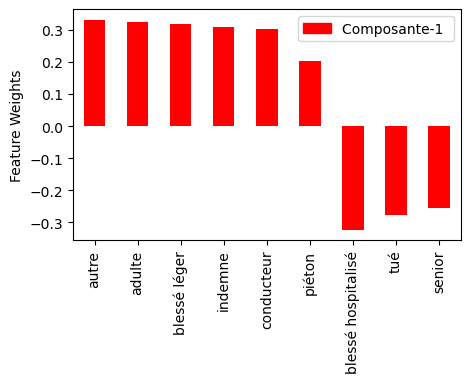

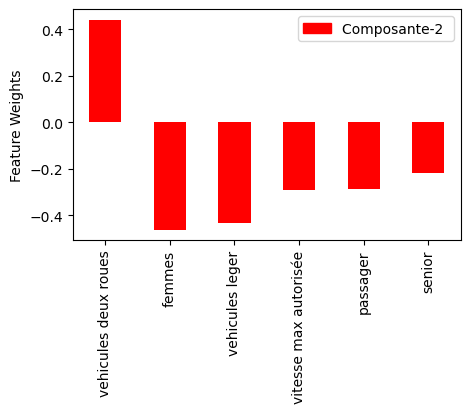

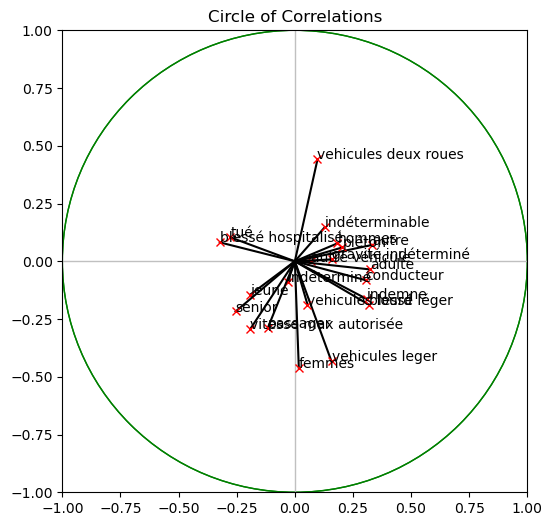

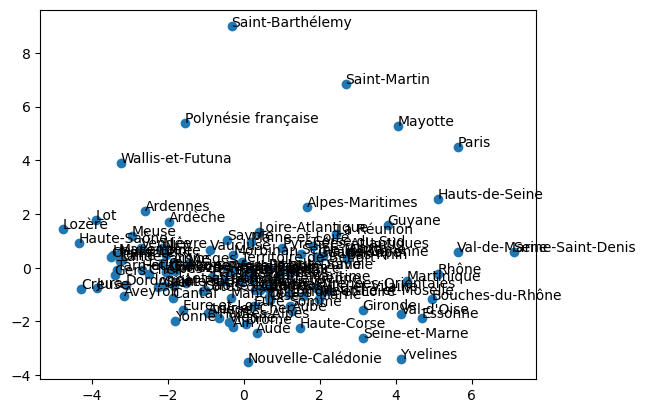

In [12]:
visualize_data("département")

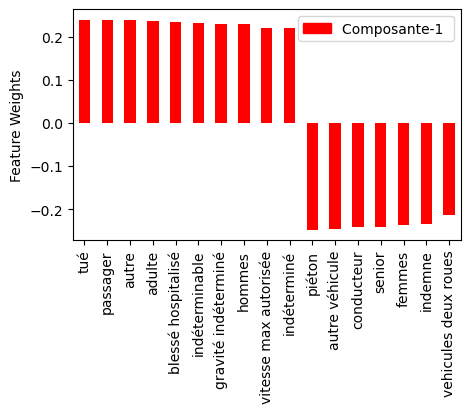

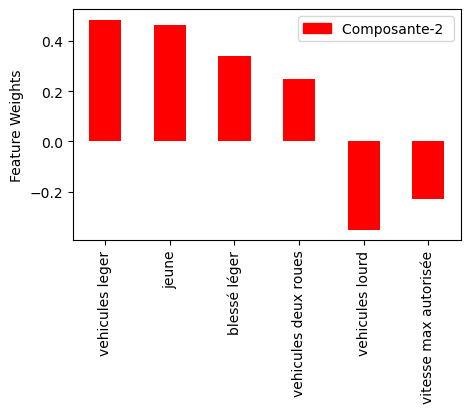

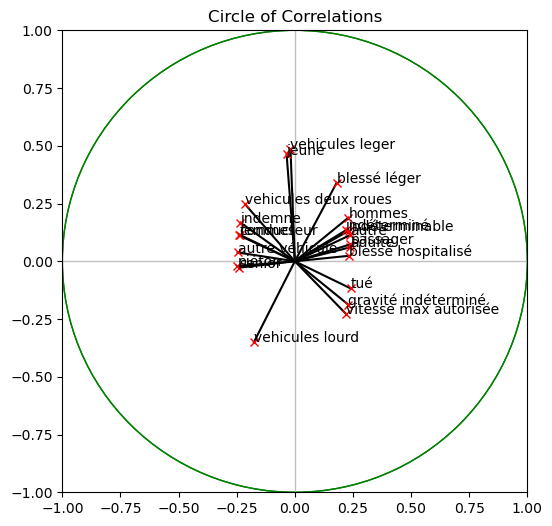

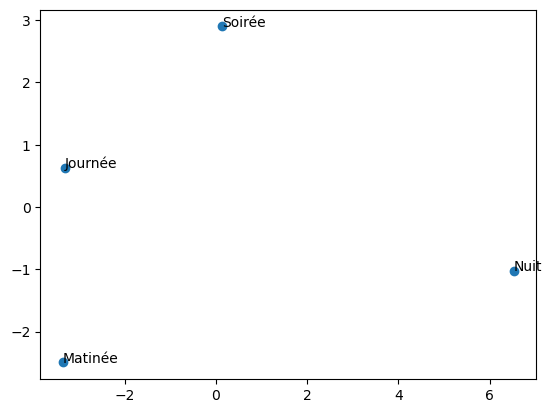

In [13]:
visualize_data("horraire")

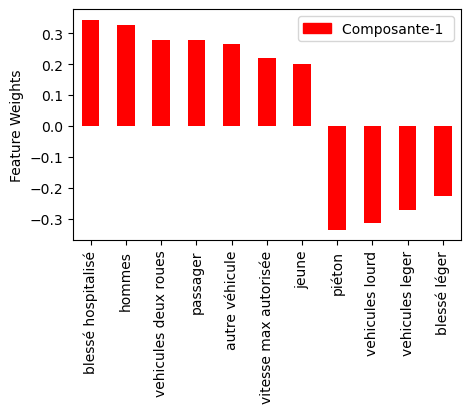

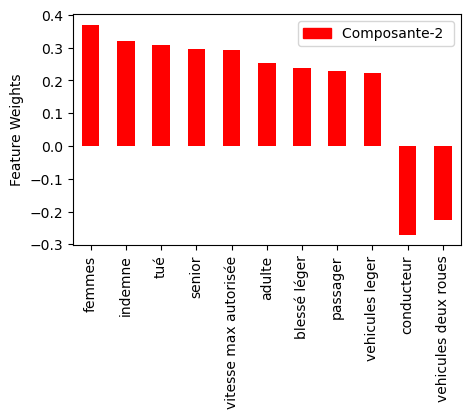

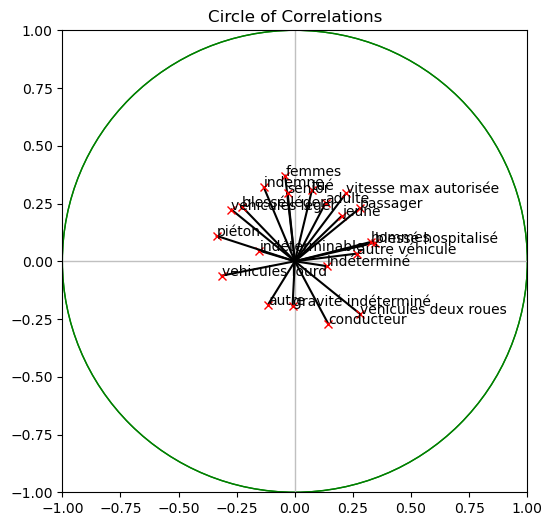

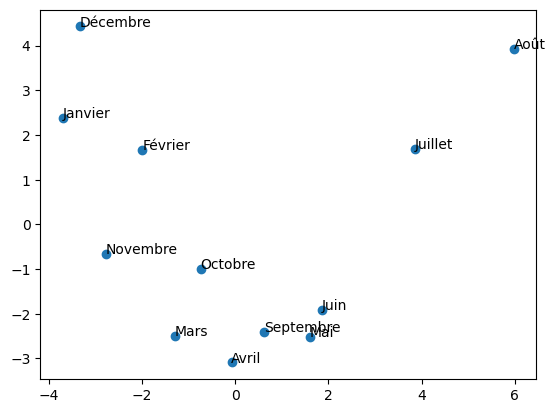

In [14]:
visualize_data("mois")